In [1]:
import math
import numpy as np

In [2]:
def ballistic_sim(initial_velocity, elevation, target_height, delta_t):
    t = 0
    x = 0
    y = 0
    v_0 = math.sin(math.radians(elevation)) * initial_velocity
    v_y = math.sin(math.radians(elevation)) * initial_velocity
    v_x = math.cos(math.radians(elevation)) * initial_velocity
    while v_y > 0 or y > target_height:
        t = t + delta_t
        x = x + v_x * delta_t
        y = y + v_y * delta_t
        v_y = v_0 - 9.81 * t
    return x, t


def ballistic_sim2(initial_velocity, elevation, target_height, delta_t):
    f = 0.00031  # from arma for 81mm
    t = 0
    x = 0
    y = 0
    v_y = math.sin(math.radians(elevation)) * initial_velocity
    v_x = math.cos(math.radians(elevation)) * initial_velocity
    while v_y > 0 or y > target_height:
        v = math.sqrt(v_x**2 + v_y**2)
        deceleration = f * v**2
        v_theta = math.atan(v_y / v_x)
        # decel_x = -1 * math.cos(v_theta) * deceleration
        # decel_y = -1 * math.sin(v_theta) * deceleration
        decel_x = -1 * deceleration
        decel_y = -1 * deceleration
        decel_y = decel_y - 9.81

        t = t + delta_t
        x = x + v_x * delta_t
        y = y + v_y * delta_t
        v_x = v_x + (decel_x * delta_t)
        v_y = v_y + (decel_y * delta_t)
    return x, t


def ballistic_sim3(initial_velocity, elevation, target_height, delta_t):
    '''Calculates the distance and time of flight for a projectile launched
    with `initial_velocity` m/s, `elevation` degrees, landing at `target_height`
    relative height from launch height, with simulation timestep of `delta_t`
    '''
    plot_points = []
    include_drag = True
    f = 0.00031  # Air Drag of 81mm mortar shell
    m = .25
    t = 0
    position = np.array([0, 0])
    gravity = np.array([0, -9.81])
    velocity = initial_velocity * np.array(
        [math.cos(math.radians(elevation)), math.sin(math.radians(elevation))]
    )
    while velocity[1] > 0 or position[1] > target_height:
        plot_points.append(position)
        position = position + velocity * delta_t

        speed = np.linalg.norm(velocity)
        drag_speed = (f * speed * speed * m)
        drag_direction = -1 * (velocity / speed)
        drag_vector = drag_speed * drag_direction
        deceleration = drag_vector + gravity if include_drag else gravity

        velocity = velocity + deceleration * delta_t
        t = t + delta_t
    return position[0], t, plot_points


# FIXME: Not taking into account relative height from observer, which means I'm
# calculating eastings/northings based on hypotenuse of the triangle rather
# than the actual x/y distance
def azimuth_from_observer_relative(
    mortar_easting: float,
    mortar_northing: float,
    observer_easting: float,
    observer_northing: float,
    obs_to_enemy_azimuth: float,
    obs_to_enemy_distance: float,
):
    # First need to calculate easting and northing of enemy
    # relative to observer
    obs_to_enemy_easting = 0.0
    obs_to_enemy_northing = 0.0

    # Due North
    if obs_to_enemy_azimuth == 0:
        obs_to_enemy_easting = 0
        obs_to_enemy_northing = obs_to_enemy_distance
    # First Quadrant
    elif obs_to_enemy_azimuth < 90:
        angle = 90 - obs_to_enemy_azimuth
        obs_to_enemy_easting = math.cos(math.radians(angle)) * obs_to_enemy_distance
        obs_to_enemy_northing = math.sin(math.radians(angle)) * obs_to_enemy_distance
    # Due East
    elif obs_to_enemy_azimuth == 90:
        obs_to_enemy_easting = obs_to_enemy_distance
        obs_to_enemy_northing = 0
    # Second Quadrant
    elif obs_to_enemy_azimuth < 180:
        angle = obs_to_enemy_azimuth - 90
        obs_to_enemy_easting = math.cos(math.radians(angle)) * obs_to_enemy_distance
        obs_to_enemy_northing = (
            -1 * math.sin(math.radians(angle)) * obs_to_enemy_distance
        )
    # Due South
    elif obs_to_enemy_azimuth == 180:
        obs_to_enemy_easting = 0
        obs_to_enemy_northing = -1 * obs_to_enemy_distance

    # Third Quadrant
    elif obs_to_enemy_azimuth < 270:
        angle = 270 - obs_to_enemy_azimuth
        obs_to_enemy_easting = (
            -1 * math.cos(math.radians(angle)) * obs_to_enemy_distance
        )
        obs_to_enemy_northing = (
            -1 * math.sin(math.radians(angle)) * obs_to_enemy_distance
        )
    # Due West
    elif obs_to_enemy_azimuth == 270:
        obs_to_enemy_easting = -1 * obs_to_enemy_distance
        obs_to_enemy_northing = 0
    # Fourth Quadrant
    else:
        angle = obs_to_enemy_azimuth - 270
        obs_to_enemy_easting = (
            -1 * math.cos(math.radians(angle)) * obs_to_enemy_distance
        )
        obs_to_enemy_northing = math.sin(math.radians(angle)) * obs_to_enemy_distance

    enemy_easting = observer_easting + obs_to_enemy_easting
    enemy_northing = observer_northing + obs_to_enemy_northing

    distance = distancefunc(
        mortar_easting, mortar_northing, enemy_easting, enemy_northing
    )

    return (
        azimuth_from_grids(
            mortar_easting, mortar_northing, enemy_easting, enemy_northing
        ),
        distance,
    )


def distancefunc(x1, y1, x2, y2):
    return math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))


def azimuth_from_grids(start_easting, start_northing, end_easting, end_northing):
    east_vector = end_easting - start_easting
    north_vector = end_northing - start_northing

    # since we want azimuth, we need to shift the axes
    # east becomes north, and north becomes west

    temp = north_vector
    north_vector = east_vector
    east_vector = temp

    initial = math.degrees(math.atan2(north_vector, east_vector))
    if initial < 0:
        initial = 360 + initial

    return initial


def enemy_pos_from_observer_relative(
    mortar_easting,
    mortar_northing,
    observer_easting,
    observer_northing,
    obs_to_enemy_azimuth,
    obs_to_enemy_distance,
):
    # First need to calculate easting and northing of enemy
    # relative to observer
    obs_to_enemy_easting = 0
    obs_to_enemy_northing = 0

    # Due North
    if obs_to_enemy_azimuth == 0:
        obs_to_enemy_easting = 0
        obs_to_enemy_northing = obs_to_enemy_distance
    # First Quadrant
    elif obs_to_enemy_azimuth < 90:
        angle = 90 - obs_to_enemy_azimuth
        obs_to_enemy_easting = math.cos(math.radians(angle)) * obs_to_enemy_distance
        obs_to_enemy_northing = math.sin(math.radians(angle)) * obs_to_enemy_distance
    # Due East
    elif obs_to_enemy_azimuth == 90:
        obs_to_enemy_easting = obs_to_enemy_distance
        obs_to_enemy_northing = 0
    # Second Quadrant
    elif obs_to_enemy_azimuth < 180:
        angle = obs_to_enemy_azimuth - 90
        obs_to_enemy_easting = math.cos(math.radians(angle)) * obs_to_enemy_distance
        obs_to_enemy_northing = (
            -1 * math.sin(math.radians(angle)) * obs_to_enemy_distance
        )
    # Due South
    elif obs_to_enemy_azimuth == 180:
        obs_to_enemy_easting = 0
        obs_to_enemy_northing = -1 * obs_to_enemy_distance

    # Third Quadrant
    elif obs_to_enemy_azimuth < 270:
        angle = 270 - obs_to_enemy_azimuth
        obs_to_enemy_easting = (
            -1 * math.cos(math.radians(angle)) * obs_to_enemy_distance
        )
        obs_to_enemy_northing = (
            -1 * math.sin(math.radians(angle)) * obs_to_enemy_distance
        )
    # Due West
    elif obs_to_enemy_azimuth == 270:
        obs_to_enemy_easting = -1 * obs_to_enemy_distance
        obs_to_enemy_northing = 0
    # Fourth Quadrant
    else:
        angle = obs_to_enemy_azimuth - 270
        obs_to_enemy_easting = (
            -1 * math.cos(math.radians(angle)) * obs_to_enemy_distance
        )
        obs_to_enemy_northing = math.sin(math.radians(angle)) * obs_to_enemy_distance

    enemy_easting = observer_easting + obs_to_enemy_easting
    enemy_northing = observer_northing + obs_to_enemy_northing
    return enemy_easting, enemy_northing


def calculate_elevation(
    initial_velocity: float, target_height: float, distance: float, upper_half: bool
):
    # Check if target is even reachable using optimal launch angle
    current_elevation = 45
    current_distance = ballistic_sim3(
        initial_velocity, current_elevation, target_height, 0.001
    )[0]
    if current_distance < distance:
        # target unreachable
        return HTMLResponse("Target Unreachable.", status_code=400)

    if upper_half:
        max_elevation = 90
        min_elevation = 45
    else:
        max_elevation = 45
        min_elevation = 0
    while abs(current_distance - distance) > 1:
        current_elevation = (min_elevation + max_elevation) / 2
        current_distance = ballistic_sim3(
            initial_velocity, current_elevation, target_height, 0.001
        )[0]
        if upper_half:
            if current_distance < distance:
                max_elevation = current_elevation
            else:
                min_elevation = current_elevation
    return {
        "elevation": round(current_elevation, 1),
        "time_to_impact": round(
            ballistic_sim3(initial_velocity, current_elevation, target_height, 0.001)[
                1
            ],
            1,
        ),
    }


def elevation_regression(distance):
    if distance > 1500:
        return -175
    else:
        return (
            603
            + -0.347 * distance
            + -1.28e-04 * distance**2
            + 1.64e-07 * distance**3
            + -1.03e-10 * distance**4
        )

In [3]:
def rotate_point_clockwise(point, deg_rotation):
    rad_rotation = math.radians(deg_rotation)
    rotation_matrix = np.array([[math.cos(rad_rotation), math.sin(rad_rotation)], [-math.sin(rad_rotation), math.cos(rad_rotation)]])
    return np.dot(rotation_matrix, point)

# Assuming box is centered at origin
def rotate_box_clockwise(point1, point2, point3, point4, deg_rotation):
    ...

In [4]:
initial_velocity = 121.3
elevation = 45

print(ballistic_sim(initial_velocity, elevation, 0, .0001))
print(ballistic_sim2(initial_velocity, elevation, 0, .0001))
print(ballistic_sim3(initial_velocity, elevation, 0, .001))

(1499.8787286697336, 17.486799999972586)
(969.710060307664, 14.06059999998057)
(1376.8399563833282, 17.081999999997894, [array([0, 0]), array([0.08577205, 0.08577205]), array([0.1715433 , 0.17153349]), array([0.25731374, 0.25728431]), array([0.34308337, 0.34302451]), array([0.4288522, 0.4287541]), array([0.51462022, 0.51447307]), array([0.60038744, 0.60018143]), array([0.68615385, 0.68587917]), array([0.77191945, 0.7715663 ]), array([0.85768425, 0.85724281]), array([0.94344824, 0.94290871]), array([1.02921143, 1.02856399]), array([1.11497381, 1.11420865]), array([1.20073538, 1.19984271]), array([1.28649615, 1.28546614]), array([1.37225612, 1.37107897]), array([1.45801528, 1.45668118]), array([1.54377363, 1.54227277]), array([1.62953118, 1.62785376]), array([1.71528792, 1.71342412]), array([1.80104386, 1.79898388]), array([1.88679899, 1.88453302]), array([1.97255332, 1.97007155]), array([2.05830684, 2.05559947]), array([2.14405956, 2.14111677]), array([2.22981147, 2.22662346]), array([2

In [5]:
def deg2EL(degrees):
    return math.radians(degrees) * 1000 - 960

In [6]:
print(calculate_elevation(121.3, 2, 1036, True)['elevation'])
elevation_regression(1036)

65.4


169.83107231155205

In [7]:
rotate_point_clockwise(np.array([-13,-18.4]), 145)

array([ 0.09517015, 22.52889129])

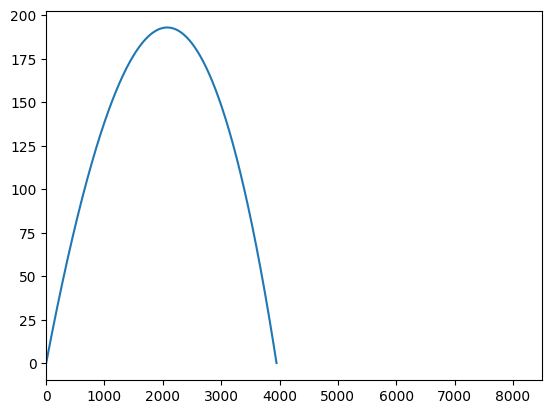

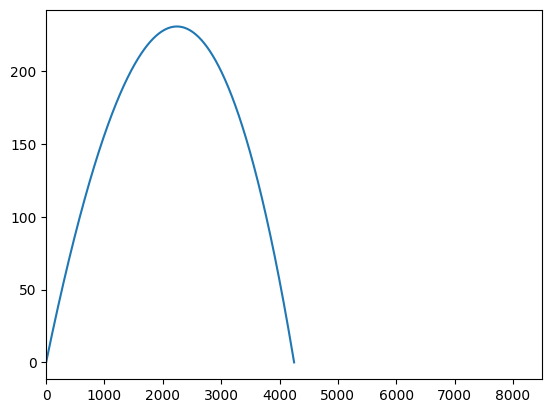

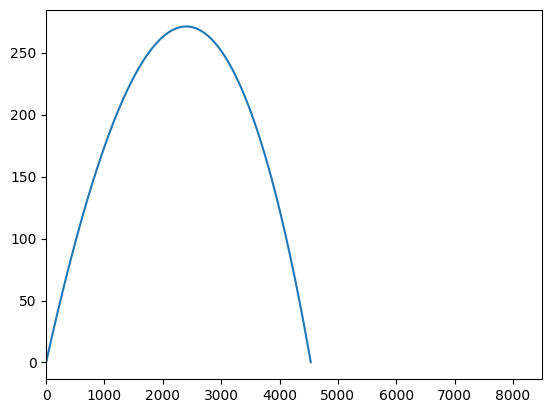

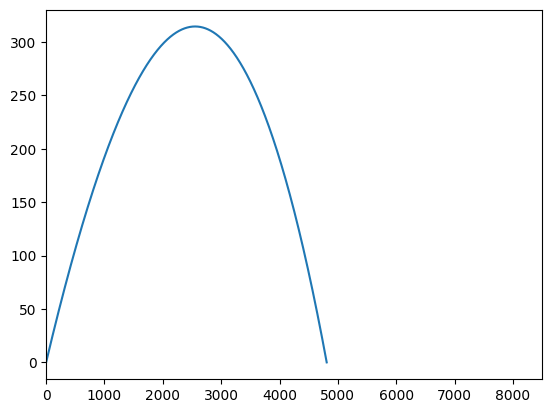

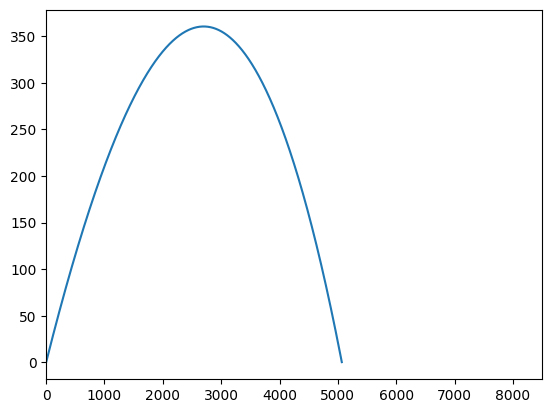

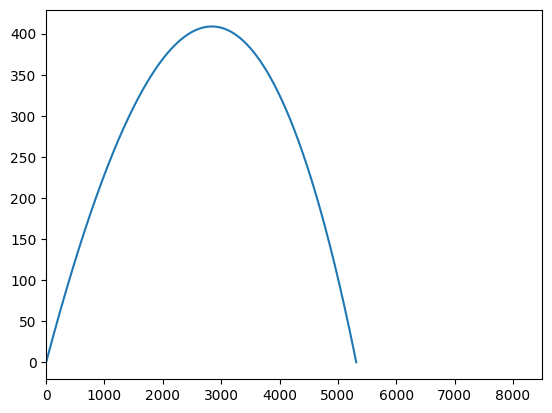

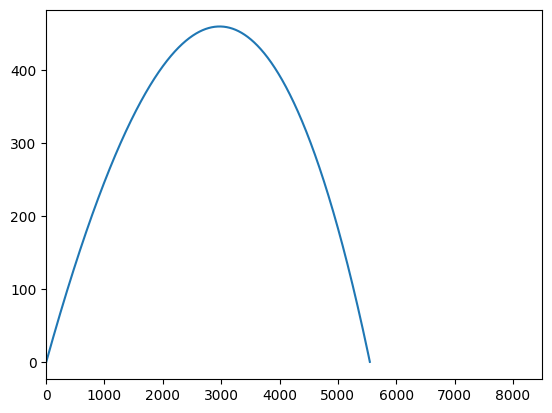

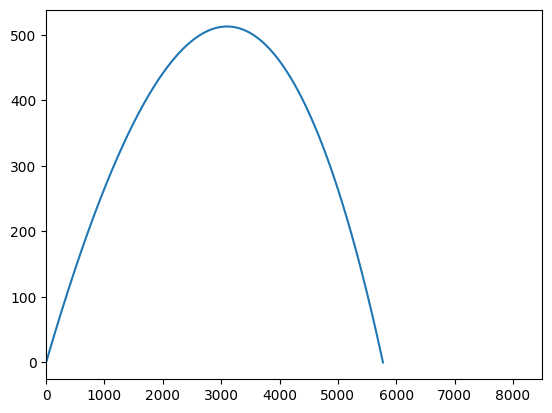

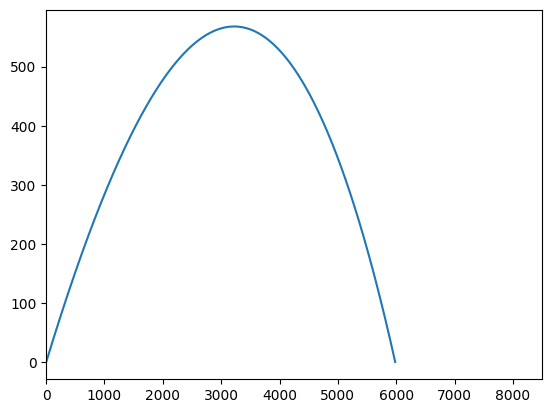

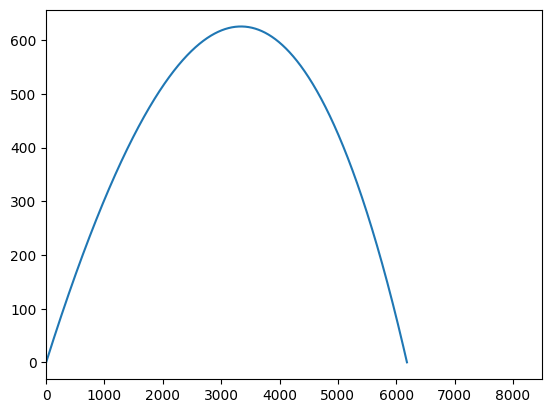

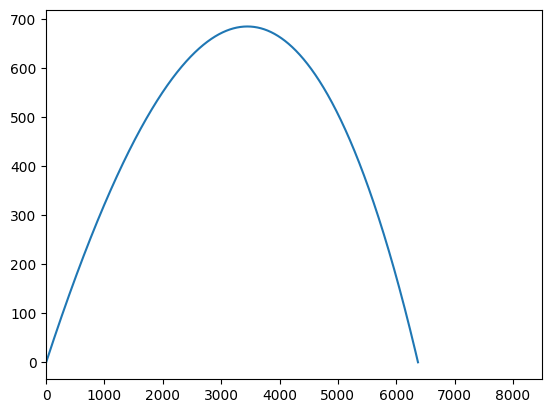

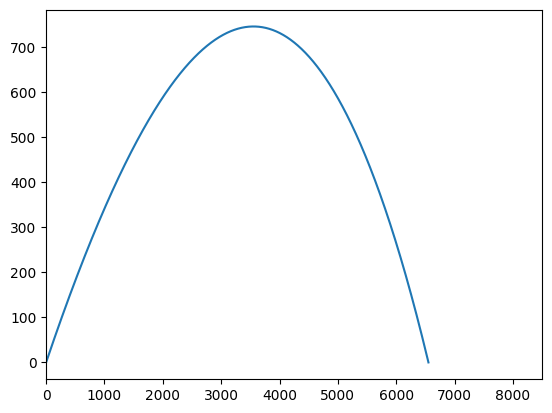

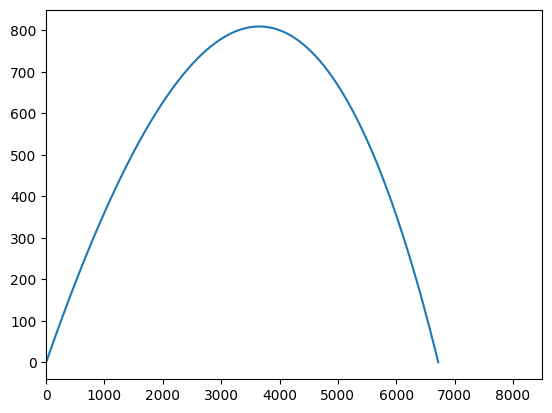

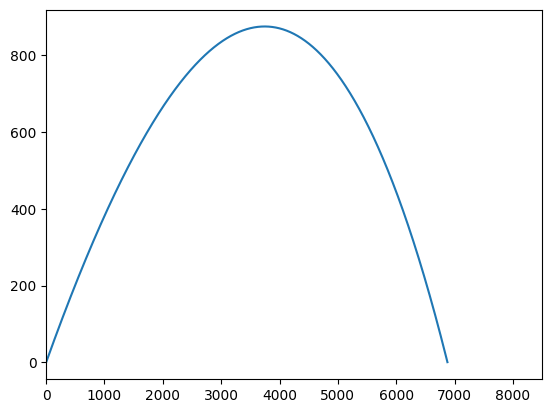

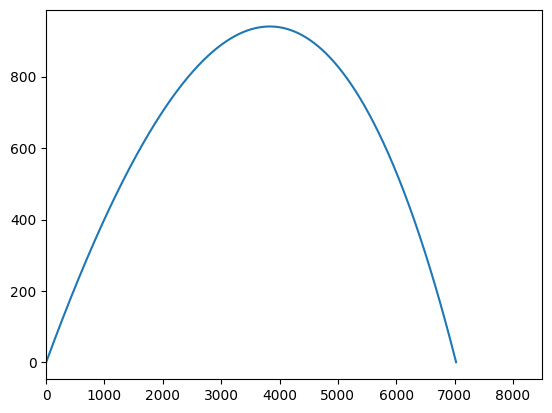

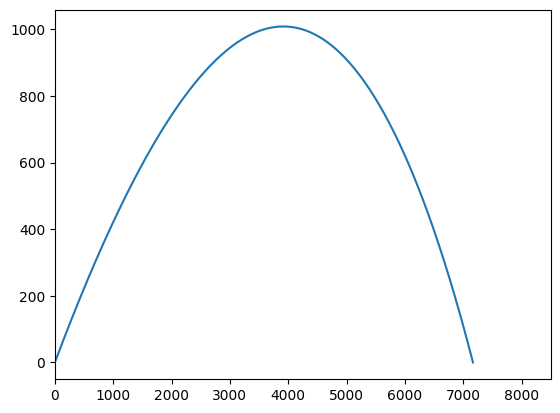

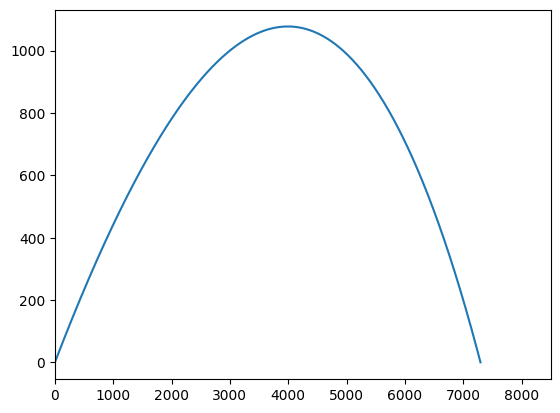

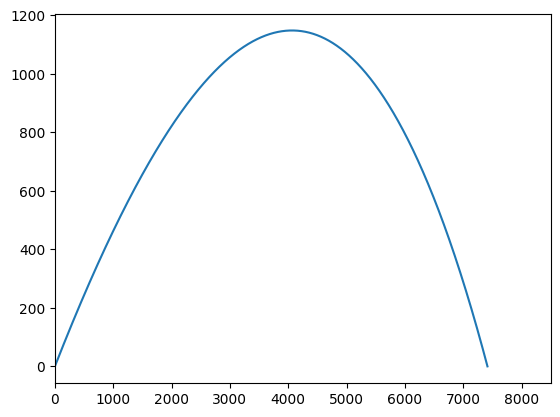

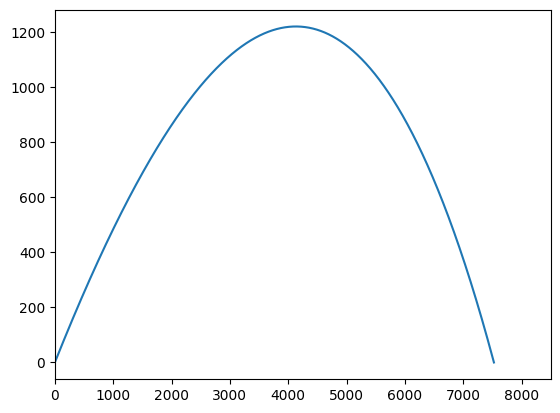

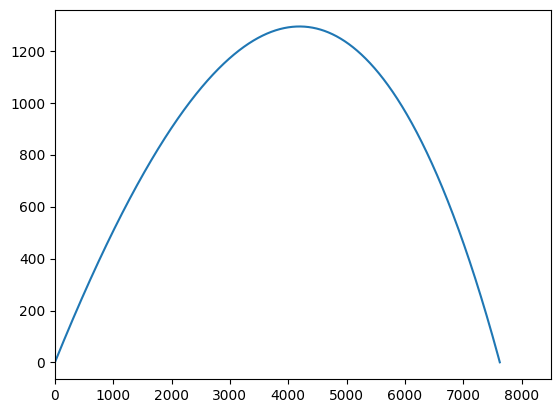

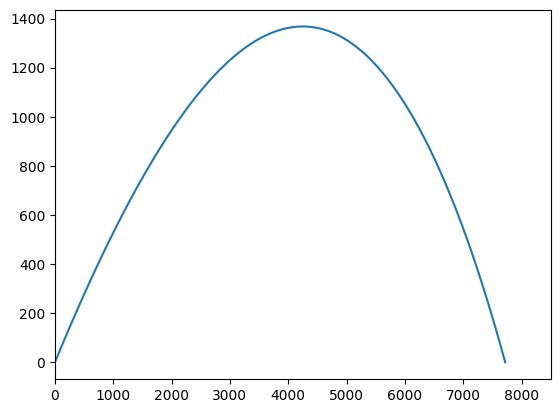

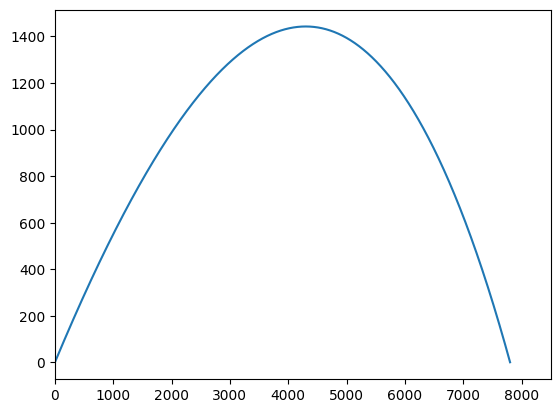

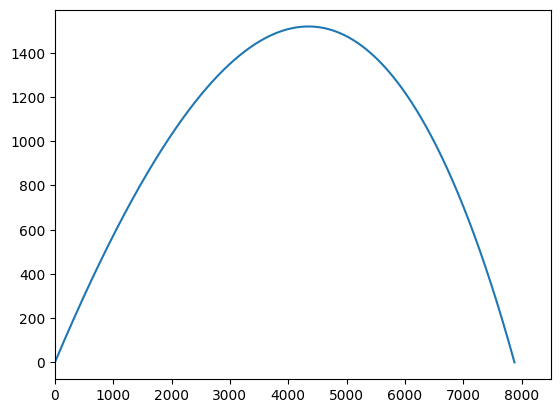

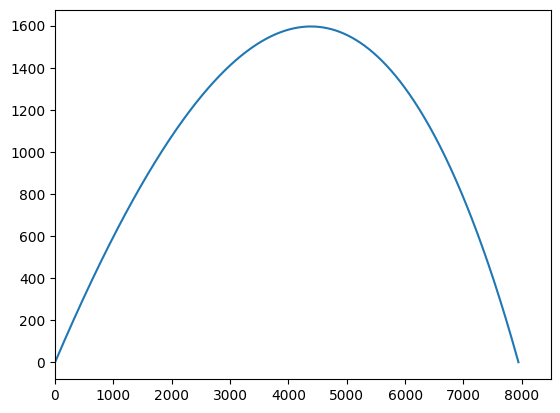

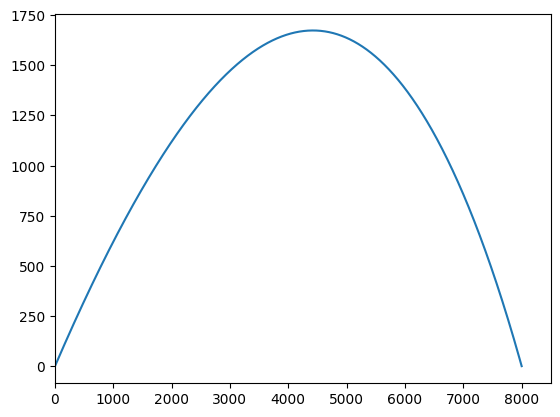

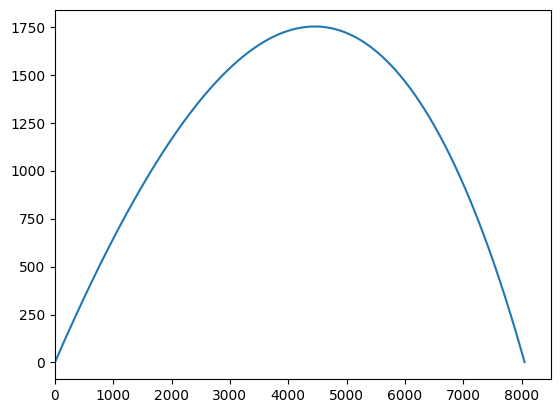

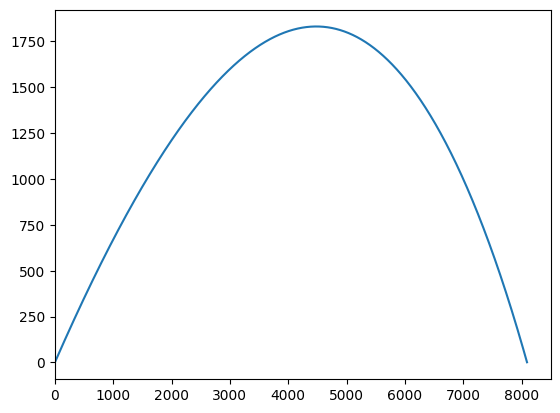

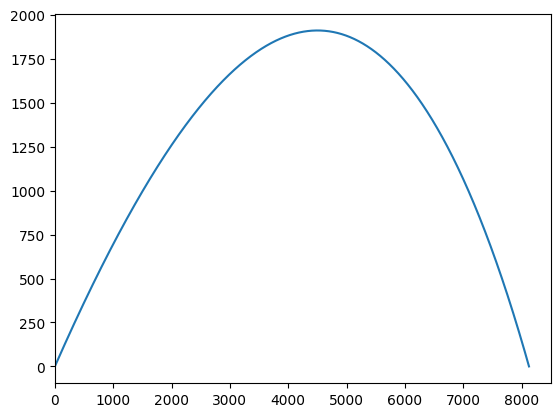

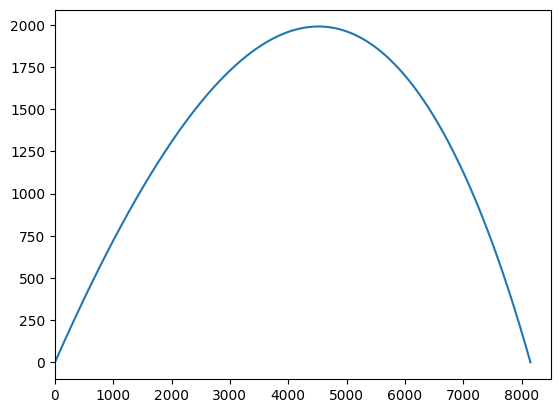

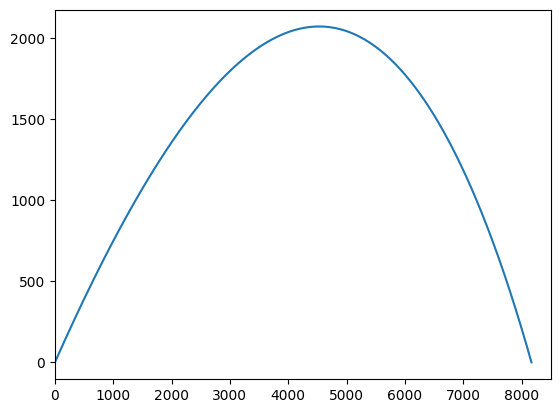

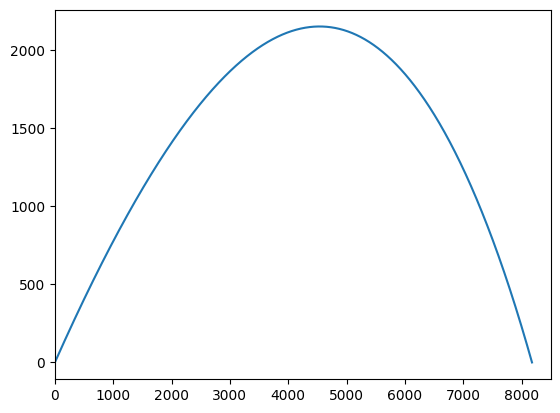

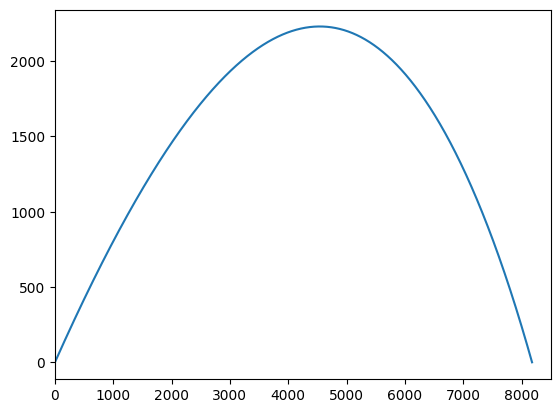

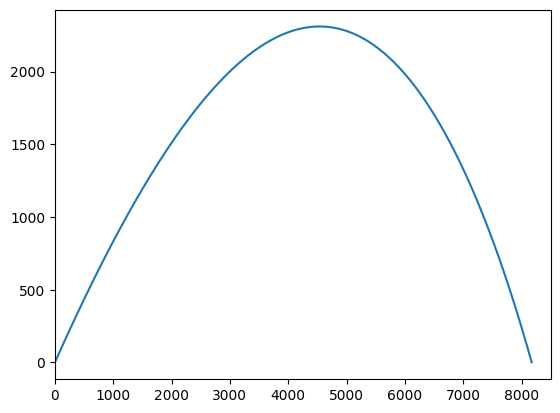

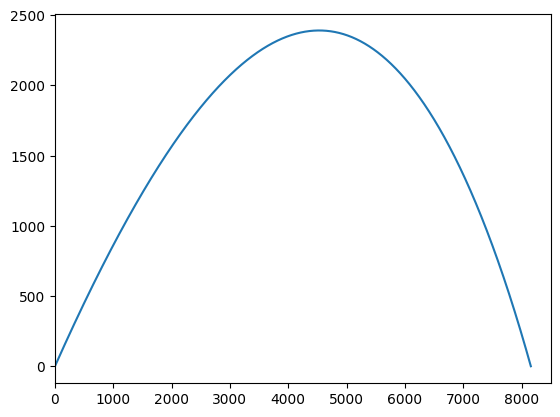

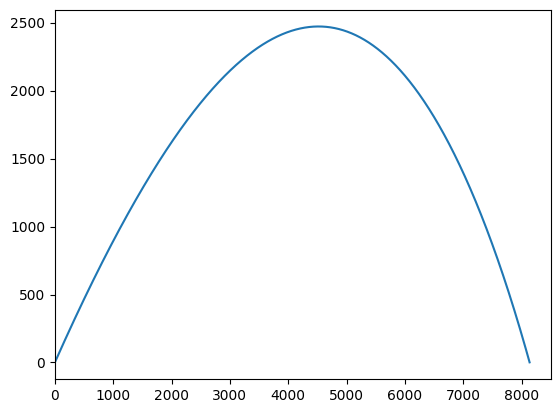

In [8]:
import matplotlib
import matplotlib.pyplot as plt

for angle in range(10,45):
    plot_points = ballistic_sim3(375, angle, 0, .001)[2]
    x = [point[0] for point in plot_points]
    y = [point[1] for point in plot_points]
    x = x[::10]
    y = y[::10]
    myplot = plt.plot(x, y)
    ax = plt.gca()
    ax.set_xlim([0,8500])
    # test = ax.plot()[0]
    # test.set_data()
    plt.show()

In [9]:
len(x)

4471